In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, MessagePassing, global_mean_pool
from torch_geometric.nn import DeepGraphInfomax
import json
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from collections import Counter
import time

c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\torch_geometric\typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\

In [ ]:
torch.manual_seed(123)
np.random.seed(123)

In [3]:
def load_data():
    adj = sp.load_npz('data/adj.npz')
    adj = adj.toarray()
    n_nodes = adj.shape[0]
    
    features = np.load('data/features.npy')
    
    train_labels = np.load('data/labels.npy')
    
    with open('data/splits.json', 'r') as f:
        splits = json.load(f)
    
    idx_train = splits['idx_train']
    idx_test = splits['idx_test']
    
    labels = np.full(n_nodes, -1, dtype=np.int64)
    labels[idx_train] = train_labels
    
    return adj, features, labels, idx_train, idx_test

def preprocess_features(features):
    features = features.astype(np.float32)
    
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = np.diag(r_inv)
    features = r_mat_inv.dot(features)
    return features

def preprocess_adj(adj):
    adj = adj + np.eye(adj.shape[0])
    
    d_inv_sqrt = np.power(np.sum(adj, axis=1), -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = np.diag(d_inv_sqrt)
    
    norm_adj = d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)
    
    return norm_adj

In [4]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [5]:
class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8, dropout=0.6):
        super(GAT, self).__init__()
        self.dropout = dropout
        
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout)
        
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, dropout=dropout)
        
        self.conv3 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=dropout)
        
    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [6]:
class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)
        self.sage3 = SAGEConv(hidden_dim, output_dim)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.sage2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.sage3(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [7]:
class MPNN(MessagePassing):
    def __init__(self, input_dim, hidden_dim, output_dim, aggr='mean'):
        super(MPNN, self).__init__(aggr=aggr)
        
        self.message_mlp = nn.Sequential(
            nn.Linear(2 * input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.update_mlp = nn.Sequential(
            nn.Linear(input_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)
    
    def message(self, x_i, x_j):
        msg = torch.cat([x_i, x_j], dim=-1)
        return self.message_mlp(msg)
    
    def update(self, aggr_out, x):
        new_embedding = torch.cat([x, aggr_out], dim=-1)
        new_embedding = self.update_mlp(new_embedding)
        return self.output_layer(new_embedding)

In [8]:
class MPNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(MPNNModel, self).__init__()
        self.mpnn1 = MPNN(input_dim, hidden_dim, hidden_dim)
        self.mpnn2 = MPNN(hidden_dim, hidden_dim, output_dim)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = self.mpnn1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.mpnn2(x, edge_index)
        
        return F.log_softmax(x, dim=1)
        

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.conv3(x, edge_index)

In [10]:
class DeepInfoMaxModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(DeepInfoMaxModel, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        
        def corruption(x, edge_index):
            return x[torch.randperm(x.size(0))], edge_index
        
        def summary(z, *args, **kwargs):
            batch = torch.zeros(z.size(0), dtype=torch.long, device=z.device)
            return torch.sigmoid(global_mean_pool(z, batch))
        
        self.dim = DeepGraphInfomax(
            hidden_channels=hidden_dim,
            encoder=self.encoder,
            summary=summary,
            corruption=corruption
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x, edge_index):
        pos_z, neg_z, summary = self.dim(x, edge_index)
        
        return F.log_softmax(self.classifier(pos_z), dim=1)

In [11]:
def train_model(model, model_name, features, edge_index, labels, 
                train_idx, val_idx, device, epochs=200, patience=20, 
                lr=0.01, weight_decay=5e-4):
    
    print(f"Training {model_name} model...")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_val_acc = 0
    best_model_state = None
    counter = 0
    
    train_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(features, edge_index)
        
        loss = F.nll_loss(out[train_idx], labels[train_idx])
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                out = model(features, edge_index)
                pred = out.argmax(dim=1)

                train_correct = pred[train_idx].eq(labels[train_idx]).sum().item()
                train_acc = train_correct / len(train_idx)
                
                val_correct = pred[val_idx].eq(labels[val_idx]).sum().item()
                val_acc = val_correct / len(val_idx)
                val_accuracies.append(val_acc)
                
                print(f'{model_name} - Epoch {epoch}, Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')
                
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model_state = model.state_dict().copy()
                    counter = 0
                else:
                    counter += 1
                
                if counter >= patience:
                    print(f"{model_name} early stopping at epoch {epoch}")
                    break
    
    model.load_state_dict(best_model_state)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title(f'{model_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Evaluation Count')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.savefig(f'results/{model_name}_training.png')
    
    return model, best_val_acc

In [12]:
def ensemble_predict(models, features, edge_index, indices, weights=None):
    all_probs = []
    
    for model_name, model in models:
        model.eval()
        with torch.no_grad():
            log_probs = model(features, edge_index)
            probs = torch.exp(log_probs)
            all_probs.append(probs[indices].cpu().numpy())
    
    all_probs = np.array(all_probs)
    
    if weights is not None:
        weights = np.array(weights).reshape(-1, 1, 1)
        weighted_probs = all_probs * weights
        avg_probs = weighted_probs.sum(axis=0)
    else:
        avg_probs = all_probs.mean(axis=0)
    
    return np.argmax(avg_probs, axis=1)

Using device: cpu
Training GCN model...
GCN - Epoch 0, Loss: 1.9464, Train Accuracy: 0.2854, Validation Accuracy: 0.3100
GCN - Epoch 10, Loss: 1.2972, Train Accuracy: 0.5783, Validation Accuracy: 0.5100
GCN - Epoch 20, Loss: 0.5318, Train Accuracy: 0.8737, Validation Accuracy: 0.7900
GCN - Epoch 30, Loss: 0.2073, Train Accuracy: 0.9747, Validation Accuracy: 0.8300
GCN - Epoch 40, Loss: 0.1165, Train Accuracy: 0.9874, Validation Accuracy: 0.8400
GCN - Epoch 50, Loss: 0.1152, Train Accuracy: 0.9798, Validation Accuracy: 0.8500
GCN - Epoch 60, Loss: 0.0989, Train Accuracy: 0.9949, Validation Accuracy: 0.8300
GCN - Epoch 70, Loss: 0.0755, Train Accuracy: 0.9924, Validation Accuracy: 0.8300
GCN - Epoch 80, Loss: 0.0851, Train Accuracy: 0.9924, Validation Accuracy: 0.8600
GCN - Epoch 90, Loss: 0.0749, Train Accuracy: 0.9949, Validation Accuracy: 0.8400
GCN - Epoch 100, Loss: 0.0696, Train Accuracy: 0.9924, Validation Accuracy: 0.8400
GCN - Epoch 110, Loss: 0.0691, Train Accuracy: 0.9975, Val

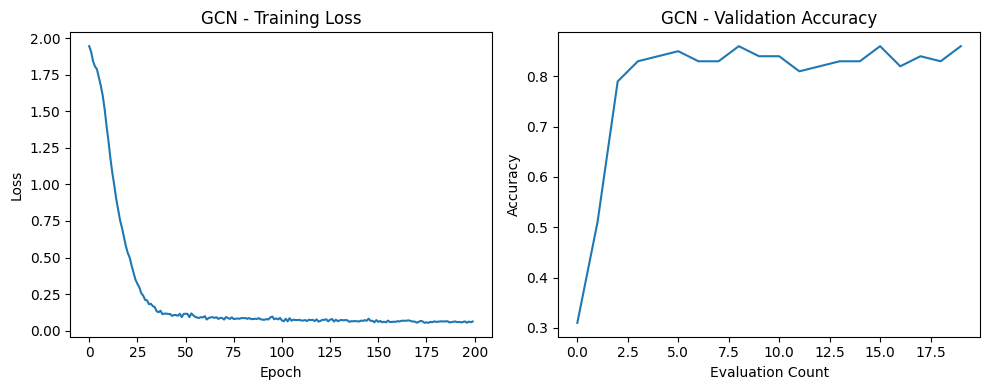

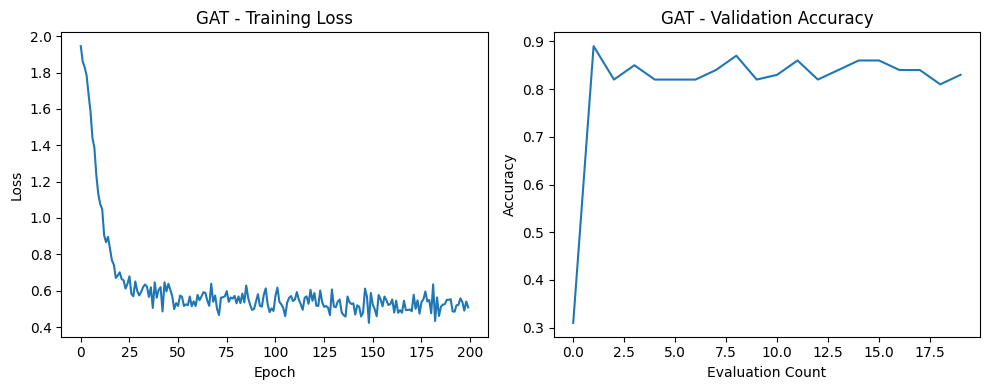

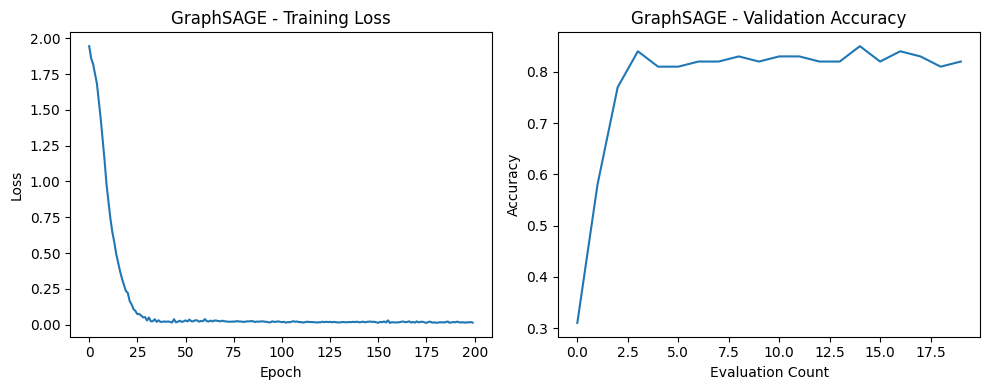

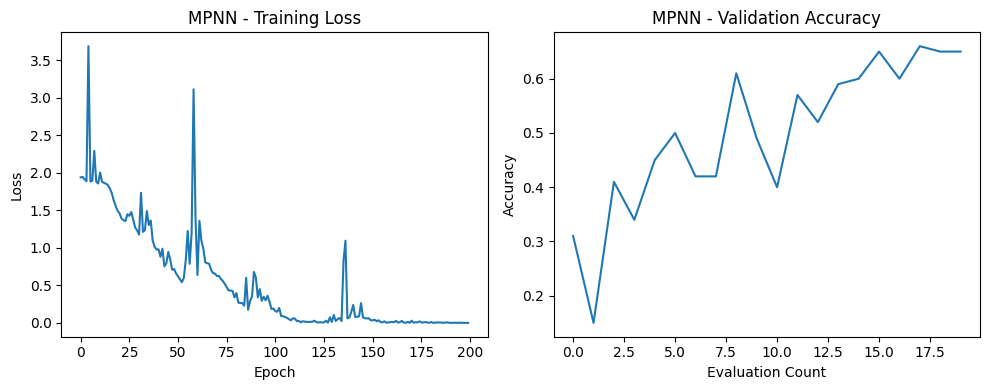

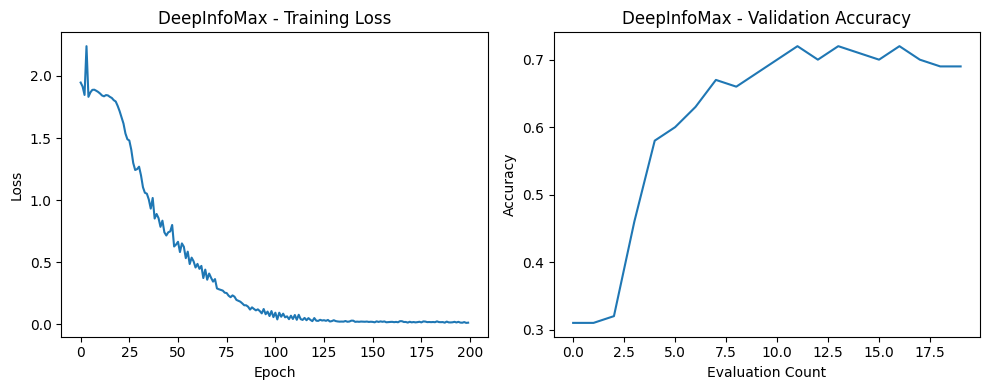

In [16]:
def main():
    os.makedirs('results', exist_ok=True)
    
    adj, features, labels, idx_train, idx_test = load_data()
    
    features = preprocess_features(features)
    norm_adj = preprocess_adj(adj)
    
    features = torch.FloatTensor(features)
    labels = torch.LongTensor(labels)
    
    edges = np.where(norm_adj > 0)
    edge_index = torch.LongTensor(np.vstack((edges[0], edges[1])))
    
    idx_train = torch.LongTensor(idx_train)
    idx_test = torch.LongTensor(idx_test)
    
    train_idx, val_idx = train_test_split(idx_train.numpy(), test_size=0.2, random_state=42)
    train_idx = torch.LongTensor(train_idx)
    val_idx = torch.LongTensor(val_idx)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    features = features.to(device)
    labels = labels.to(device)
    edge_index = edge_index.to(device)
    train_idx = train_idx.to(device)
    val_idx = val_idx.to(device)
    idx_test = idx_test.to(device)
    
    models_to_train = [
        ('GCN', GCN(input_dim=features.shape[1], hidden_dim=256, output_dim=7, dropout=0.5)),
        ('GAT', GAT(input_dim=features.shape[1], hidden_dim=32, output_dim=7, heads=8, dropout=0.6)),
        ('GraphSAGE', GraphSAGE(input_dim=features.shape[1], hidden_dim=256, output_dim=7, dropout=0.5)),
        ('MPNN', MPNNModel(input_dim=features.shape[1], hidden_dim=256, output_dim=7, dropout=0.5)),
        ('DeepInfoMax', DeepInfoMaxModel(input_dim=features.shape[1], hidden_dim=256, output_dim=7, dropout=0.5))
    ]
    
    trained_models = []
    model_accuracies = []
    
    for model_name, model in models_to_train:
        try:
            trained_model, val_acc = train_model(
                model, 
                model_name, 
                features, 
                edge_index, 
                labels,
                train_idx, 
                val_idx, 
                device, 
                epochs=200, 
                patience=20
            )
            
            trained_models.append((model_name, trained_model))
            model_accuracies.append(val_acc)
            
            torch.save(trained_model.state_dict(), f'results/{model_name}_model.pth')
        except Exception as e:
            print(f"Error training {model_name}: {e}")
            continue
    
    if len(trained_models) == 0:
        print("All models training failed, cannot continue")
        return
    
    total_acc = sum(model_accuracies)
    model_weights = [acc / total_acc for acc in model_accuracies]
    
    for (model_name, _), acc, weight in zip(trained_models, model_accuracies, model_weights):
        print(f"{model_name} - Validation Accuracy: {acc:.4f}, Ensemble Weight: {weight:.4f}")
    
    ensemble_preds = ensemble_predict(trained_models, features, edge_index, idx_test, weights=model_weights)
    preds = ensemble_preds
    np.savetxt('submission.txt', preds, fmt='%d')
if __name__ == "__main__":
    main()